# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='./Reacher_Windows_x86_64/Reacher.exe')
# env = UnityEnvironment(file_name='./Reacher_Windows_x86_64_v1/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
import random
import torch
import numpy as np
from collections import deque
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline

E:\Anaconda2\envs\drlnd\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda2\envs\drlnd\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda2\envs\drlnd\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda2\envs\drlnd\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:5

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
%tensorboard --logdir runs/ppo --port=6088

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 23008.

In [11]:
import ppo_model
import ppo_util

from ppo_model import Policy
from ppo_util import clipped_surrogate, collect_trajectories, normalize_reward

In [20]:
def collect_trajectories(env, brain_name, policy, states, actions, action_size, num_agents=1, tmax=1000): 
    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]
    done = False
# collect trajectories
    for t in range(tmax):
        states  = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).float().to(device)
        # probs will only be used as the pi_old
        # no gradient propagation is needed
        actions, log_probs = policy(states, actions)
        actions = actions.detach()
        log_probs = log_probs.detach()

        # we take one action and move forward
        actions = actions.data.numpy()
        env_info    = env.step(actions)[brain_name]        # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones   = env_info.local_done
      
        # store the result
        state_list.append(next_states)
        reward_list.append(rewards)
        prob_list.append(log_probs)
        action_list.append(actions)
        
        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        states = next_states
        if np.any(dones):
            done = True
            break

    # return pi_theta, states, actions, rewards, probability
    return prob_list, state_list, action_list, reward_list, done

In [21]:
def clipped_surrogate(agent, policy, old_log_probs, states, actions, rewards_normalized, epsilon=0.05, beta=0.01):
    
    # convert everything into pytorch tensors and move to gpu if available
    actions       = torch.from_numpy(np.stack(actions)).float().to(device=device)
    states        = torch.from_numpy(np.stack(states)).float().to(device=device)
    old_log_probs = torch.stack(old_log_probs).float().to(device=device)
    temp_rewards  = np.stack(rewards_normalized)
    rewards       = torch.from_numpy(np.expand_dims(temp_rewards, -1)).float().to(device=device)

    # convert states to policy (or probability)
    new_actions, new_log_probs = policy(states, actions)
    # ratio for clipping
    new_probs = new_log_probs.exp()
    old_probs = old_log_probs.exp()
    ratio = new_probs/old_probs
    agent.writer.add_scalar('ratio',  torch.mean(ratio), agent.g_step)
    # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan  
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
   
    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    loss1 = torch.mean(clipped_surrogate)
    loss2 = torch.mean(beta*entropy)
    agent.writer.add_scalar('surrrogate_loss',  loss1, agent.g_step)
    agent.writer.add_scalar('entropy_loss',     loss2, agent.g_step)
    return loss1 + loss2

In [22]:
def normalize_reward(rewards, discount):
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
      # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    return rewards_future

In [23]:
def normalize_reward(rewards, discount):
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
      # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]

    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    return rewards_normalized

In [24]:
class Agent:
    def __init__(self, writer):
        self.g_step = 0
        self.writer = writer

In [25]:
def ppo(n_episodes=100, print_every=10, tmax=1000, discount= 0.98, optimization_epochs=5, mini_batch_size=64, beta=0.5):
    scores_deque = deque(maxlen=print_every)
    scores_global = []
    # keep track of progress
    agent = Agent(writer)
    for i_episode in range(1, n_episodes+1):
        scores    = 0
        env_info = env.reset(train_mode=True)[brain_name]
        states   = env_info.vector_observations
        # start all random parallel agents
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        while True:
            old_probs_l, states_l, actions_l, rewards_l, done = collect_trajectories(env, brain_name, policy, states, actions, num_agents, action_size, tmax=tmax)
            step_rewards = np.sum(rewards_l, axis=0)
            scores += step_rewards
            if done:
                break 
            states  = states_l[-1]
            actions = actions_l[-1]    
#             pdb.set_trace()
            rewards_normalized = normalize_reward(rewards_l, discount)
            agent.writer.add_scalar('rewards',  step_rewards[0], agent.g_step)
            agent.writer.add_scalar('action_1', actions[0][0], agent.g_step)
            agent.writer.add_scalar('action_2', actions[0][1], agent.g_step)
            agent.writer.add_scalar('action_3', actions[0][2], agent.g_step)
            agent.writer.add_scalar('action_4', actions[0][3], agent.g_step)
            for _ in range(optimization_epochs):
                sampler = np.random.choice(len(rewards_normalized), mini_batch_size)
                sample_old_probs = [old_probs_l[sample] for sample in sampler]
                sample_states    = [states_l[sample] for sample in sampler ]
                sample_actions   = [actions_l[sample] for sample in sampler ]
                sample_rewards   = [rewards_normalized[sample] for sample in sampler]
#                 pdb.set_trace()
                L = -clipped_surrogate(agent, policy, sample_old_probs, sample_states, sample_actions, sample_rewards, beta=beta)
                agent.writer.add_scalar('loss', L, agent.g_step)
                optimizer.zero_grad()
                L.backward()
                optimizer.step()
                agent.g_step += 1
#                 del L
                # the regulation term also reduces
                # this reduces exploration in later runs
                beta *= 0.9995
                writer.add_scalar('beta', beta, agent.g_step)
        # get the average reward of the parallel environments           
        score = np.mean(scores)
        scores_deque.append(score)
        agent.writer.add_scalar('score', score, agent.g_step)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(policy.state_dict(), 'checkpoint_ppo.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    return scores_global

In [32]:
LR1_SIZE = 64
LR2_SIZE = 64
LR=0.5e-4

In [33]:
policy=Policy(state_size=state_size, action_size=action_size, seed=88, fc1_units=LR1_SIZE, fc2_units=LR2_SIZE).to(device)
# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=LR)

In [34]:
from datetime import datetime

log_location = 'runs/ppo/v3_' + str(datetime.now().strftime('%Y_%m_%d_%H_%M')) 

In [35]:
writer = SummaryWriter(log_dir=log_location)

In [36]:
scores = ppo(n_episodes=1000, tmax=990, optimization_epochs=3, mini_batch_size=1000, beta=0.05)

Episode 10	Average Score: 0.37
Episode 20	Average Score: 0.43
Episode 30	Average Score: 0.43
Episode 40	Average Score: 0.39
Episode 50	Average Score: 0.38
Episode 60	Average Score: 0.35
Episode 70	Average Score: 0.28
Episode 80	Average Score: 0.19
Episode 90	Average Score: 0.18
Episode 100	Average Score: 0.18
Episode 110	Average Score: 0.14
Episode 120	Average Score: 0.17
Episode 130	Average Score: 0.18
Episode 140	Average Score: 0.32
Episode 150	Average Score: 0.40
Episode 160	Average Score: 0.45
Episode 170	Average Score: 0.50
Episode 180	Average Score: 0.38
Episode 190	Average Score: 0.31
Episode 200	Average Score: 0.21
Episode 210	Average Score: 0.11
Episode 220	Average Score: 0.08
Episode 230	Average Score: 0.22
Episode 240	Average Score: 0.41
Episode 250	Average Score: 0.64
Episode 260	Average Score: 0.73
Episode 270	Average Score: 0.96
Episode 280	Average Score: 0.91
Episode 290	Average Score: 0.91
Episode 300	Average Score: 0.86
Episode 310	Average Score: 0.81
Episode 320	Avera

In [38]:
scores;

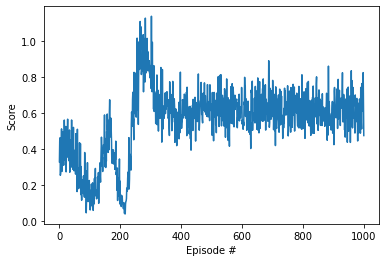

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [40]:
env.close()